Every feature depends on the team:
- goals scores (at home and away)
- goals conceded (at home and away)
- goal difference
- current ranking
- average ranking in the last 5 seasons for example
- current streak of games (average number of points gained in the last X games)
- head2head (goals scored, conceded, wins, ties...)
- general win/tie/loses rate of each team
- Number of promotions and relegations ?
- biggest win ?
- longest undefeated streak ?
- day and hour ?

In [68]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
conn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


In [8]:
df = df.loc[(~df['score'].isnull())]
display(df.head())
display(df.tail())

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


,season,division,matchday,date,time,home_team,away_team,score
48345,2021-2022,2,3,8/28/21,10:00 PM,Ponferradina,Girona,2:1
48346,2021-2022,2,3,8/29/21,5:00 PM,SD Amorebieta,UD Almería,2:1
48347,2021-2022,2,3,8/29/21,7:30 PM,CD Lugo,Real Valladolid,0:2
48348,2021-2022,2,3,8/29/21,7:30 PM,Real Sociedad B,CF Fuenlabrada,0:0
48349,2021-2022,2,3,8/29/21,10:00 PM,Burgos CF,SD Eibar,0:1


In [9]:
# Separate the home score and the away score.
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])


# Calculate home team total goals
home_goals = df.groupby('home_team')['home_score'].sum().reset_index()
home_goals.columns = ['team', 'home_goals']

# Calculate away team total goals
away_goals = df.groupby('away_team')['away_score'].sum().reset_index()
away_goals.columns = ['team', 'away_goals']

# Merge the home and away goals
all_time = pd.merge(home_goals, away_goals, on='team', how='outer').fillna(0)

# Calculate total goals
all_time['total_goals'] = all_time['home_goals'] + all_time['away_goals']

# Calculate total concedes when playing at home
home_conceding = df.groupby('home_team')['away_score'].sum().reset_index()
home_conceding.columns = ['team', 'concedes_home']

# Calculate total concedes when visiting
away_conceding = df.groupby('away_team')['home_score'].sum().reset_index()
away_conceding.columns = ['team', 'concedes_away']

# Calculate total concedes
all_time_concedes = pd.merge(home_conceding, away_conceding, on='team', how='outer').fillna(0)
all_time_concedes['total_concedes'] = all_time_concedes['concedes_home'] + all_time_concedes['concedes_away']
all_time = pd.merge(all_time, all_time_concedes, on='team', how='outer').fillna(0)

home_counts = df['home_team'].value_counts()
away_counts = df['away_team'].value_counts()
total_counts = home_counts.add(away_counts, fill_value=0)
df['home_app_home'] = df['home_team'].map(home_counts)
df['home_app_total'] = df['home_team'].map(total_counts)
df['away_app_away'] = df['away_team'].map(away_counts)
df['away_app_total'] = df['away_team'].map(total_counts)

df = df.merge(all_time[['team','home_goals','total_goals','concedes_home','total_concedes']], left_on='home_team', right_on='team', how='outer').fillna(0)
df = df.merge(all_time[['team','away_goals','total_goals','concedes_away','total_concedes']], left_on='away_team', right_on='team', suffixes=('_home', '_away'), how='outer').fillna(0)
df = df.drop('team_home', axis=1)
df = df.drop('team_away', axis=1)
df = df.sort_values(by='season', ascending=True)

df['home_goals_ratio'] = df['home_goals'] / df['home_app_home']
df['away_goals_ratio'] = df['away_goals'] / df['away_app_away']
df['total_goals_home_ratio'] = df['total_goals_home'] / df['home_app_total']
df['total_goals_away_ratio'] = df['total_goals_away'] / df['away_app_total']

df['concedes_home_ratio'] = df['concedes_home'] / df['home_app_home']
df['concedes_away_ratio'] = df['concedes_away'] / df['away_app_away']
df['total_concedes_home_ratio'] = df['total_concedes_home'] / df['home_app_total']
df['total_concedes_away_ratio'] = df['total_concedes_away'] / df['away_app_total']

#df = df.drop('home_app_home', axis=1)
#df = df.drop('home_app_total', axis=1)
#df = df.drop('away_app_away', axis=1)
#df = df.drop('away_app_total', axis=1)

df['goal_diff_home'] = df['home_goals'] - df['concedes_home']
df['goal_diff_home_total'] = df['total_goals_home'] - df['total_concedes_home']
df['goal_diff_away'] = df['away_goals'] - df['concedes_away']
df['goal_diff_away_total'] = df['total_goals_away'] - df['total_concedes_away']
df['goal_diff_home_ratio'] = df['home_goals_ratio'] - df['concedes_home_ratio']
df['goal_diff_home_total_ratio'] = df['total_goals_home_ratio'] - df['total_concedes_home_ratio']
df['goal_diff_away_ratio'] = df['away_goals_ratio'] - df['concedes_away_ratio']
df['goal_diff_away_total_ratio'] = df['total_goals_away_ratio'] - df['total_concedes_away_ratio']

# Define whether it is a home or away win.
df['result'] = df.apply(lambda row: '1' if row['home_score'] > row['away_score']
                                        else '2' if row['home_score'] < row['away_score']
                                        else 'X', axis=1)



# Convert 'date' column to datetime with specified format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')

# Add a 'weekday' column with weekday names
df['weekday'] = df['date'].dt.day_name()
df['weekday_num'] = df['date'].dt.dayofweek


# Convert 'time' column to datetime (adjusting format as "hour:minute AM/PM")
# df['time_absolute'] = pd.to_datetime(df['time'], format='%I:%M %p')

# Extract the hour from the converted 'time' column
# df['hour'] = df['time_absolute'].dt.hour

df = df.drop('weekday', axis=1)

,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,goal_diff_home,goal_diff_home_total,goal_diff_away,goal_diff_away_total,goal_diff_home_ratio,goal_diff_home_total_ratio,goal_diff_away_ratio,goal_diff_away_total_ratio,result,weekday_num
0,1928-1929,1,1,2029-02-10,0,Arenas Club,Athletic Madrid,2:3,2,3,...,60,-118,-78,-32,0.666667,-0.655556,-1.591837,-0.326531,2,5
6246,1928-1929,1,12,2029-05-09,0,Catalunya,Espanyol,0:3,0,3,...,10,-34,-1308,-204,0.370370,-0.629630,-0.904564,-0.070564,2,2
6242,1928-1929,1,10,2029-04-28,0,Real Unión,Espanyol,4:3,4,3,...,46,-144,-1308,-204,0.403509,-0.631579,-0.904564,-0.070564,1,5
6238,1928-1929,1,18,2029-06-23,0,Athletic Madrid,Espanyol,7:1,7,1,...,46,-32,-1308,-204,0.938776,-0.326531,-0.904564,-0.070564,1,5
6153,1928-1929,1,2,2029-02-17,0,Athletic,Espanyol,9:0,9,0,...,1685,927,-1308,-204,1.155693,0.317792,-0.904564,-0.070564,1,5
6067,1928-1929,1,8,2029-04-07,0,Barcelona,Espanyol,1:0,1,0,...,2705,3008,-1308,-204,1.854010,1.031196,-0.904564,-0.070564,1,5
6022,1928-1929,1,14,2029-05-30,0,Racing,Espanyol,1:1,1,1,...,862,-411,-1308,-204,0.668217,-0.159302,-0.904564,-0.070564,X,2
6015,1928-1929,1,5,2029-03-10,0,Donostia,Espanyol,1:1,1,1,...,71,-41,-1308,-204,1.092308,-0.315385,-0.904564,-0.070564,X,5
5929,1928-1929,1,15,2029-06-02,0,Real Madrid,Espanyol,2:0,2,0,...,2586,2962,-1308,-204,1.774880,1.015427,-0.904564,-0.070564,1,5
5922,1928-1929,1,16,2029-06-09,0,Arenas Club,Espanyol,3:0,3,0,...,60,-118,-1308,-204,0.666667,-0.655556,-0.904564,-0.070564,1,5


In [49]:
y = df.loc[:,'result']

cols_to_drop = ['score','home_score','away_score','result']
X = df.drop(columns=cols_to_drop)
X = X.drop(columns=['date', 'time'])
print(X.columns)
y[:10,]

Index(['season', 'division', 'matchday', 'home_team', 'away_team',
       'home_app_home', 'home_app_total', 'away_app_away', 'away_app_total',
       'home_goals', 'total_goals_home', 'concedes_home',
       'total_concedes_home', 'away_goals', 'total_goals_away',
       'concedes_away', 'total_concedes_away', 'home_goals_ratio',
       'away_goals_ratio', 'total_goals_home_ratio', 'total_goals_away_ratio',
       'concedes_home_ratio', 'concedes_away_ratio',
       'total_concedes_home_ratio', 'total_concedes_away_ratio',
       'goal_diff_home', 'goal_diff_home_total', 'goal_diff_away',
       'goal_diff_away_total', 'goal_diff_home_ratio',
       'goal_diff_home_total_ratio', 'goal_diff_away_ratio',
       'goal_diff_away_total_ratio', 'weekday_num'],
      dtype='object')


0       2
6246    2
6242    1
6238    1
6153    1
6067    1
6022    X
6015    X
5929    1
5922    1
Name: result, dtype: object

In [45]:
X.corr(numeric_only=True).style.background_gradient("coolwarm", vmin=-1, vmax=1)

,division,matchday,home_app_home,home_app_total,away_app_away,away_app_total,home_goals,total_goals_home,concedes_home,total_concedes_home,away_goals,total_goals_away,concedes_away,total_concedes_away,home_goals_ratio,away_goals_ratio,total_goals_home_ratio,total_goals_away_ratio,concedes_home_ratio,concedes_away_ratio,total_concedes_home_ratio,total_concedes_away_ratio,goal_diff_home,goal_diff_home_total,goal_diff_away,goal_diff_away_total,goal_diff_home_ratio,goal_diff_home_total_ratio,goal_diff_away_ratio,goal_diff_away_total_ratio,weekday_num
division,1.000000,0.090943,-0.582116,-0.582144,-0.582147,-0.582119,-0.579332,-0.578211,-0.567267,-0.561450,-0.573865,-0.578199,-0.555814,-0.561429,-0.431802,-0.398278,-0.439732,-0.439779,0.118829,0.035235,0.066705,0.066880,-0.535051,-0.345329,0.226944,-0.345373,-0.441094,-0.407500,-0.243355,-0.407541,0.054092
matchday,0.090943,1.000000,-0.051647,-0.051653,-0.053961,-0.053953,-0.062079,-0.060027,-0.050582,-0.054492,-0.058420,-0.062330,-0.058898,-0.056924,-0.101582,-0.052734,-0.087895,-0.089974,-0.019990,-0.088593,-0.075530,-0.076524,-0.063994,-0.041743,0.027605,-0.042816,-0.090438,-0.035273,0.035818,-0.036536,0.045323
home_app_home,-0.582116,-0.051647,1.000000,0.999999,0.322954,0.322947,0.949933,0.947277,0.991148,0.984883,0.315601,0.318033,0.309406,0.312172,0.585685,0.212805,0.595862,0.236722,-0.252397,-0.019200,-0.182962,-0.038565,0.837516,0.464713,-0.132067,0.184747,0.623648,0.600294,0.130300,0.220701,-0.020456
home_app_total,-0.582144,-0.051653,0.999999,1.000000,0.322963,0.322955,0.950017,0.947368,0.991143,0.984866,0.315606,0.318038,0.309415,0.312180,0.585830,0.212807,0.596033,0.236727,-0.252412,-0.019196,-0.183008,-0.038560,0.837649,0.464931,-0.132076,0.184746,0.623789,0.600462,0.130299,0.220703,-0.020459
away_app_away,-0.582147,-0.053961,0.322954,0.322963,1.000000,0.999999,0.318653,0.318011,0.314769,0.312205,0.938929,0.947455,0.977221,0.984848,0.233153,0.538852,0.236597,0.596252,-0.071462,-0.127316,-0.038392,-0.183380,0.292500,0.184630,-0.503178,0.465215,0.240199,0.220555,0.387355,0.600683,-0.027938
away_app_total,-0.582119,-0.053953,0.322947,0.322955,0.999999,1.000000,0.318647,0.318006,0.314761,0.312197,0.938825,0.947364,0.977246,0.984865,0.233148,0.538652,0.236593,0.596082,-0.071466,-0.127263,-0.038396,-0.183334,0.292496,0.184632,-0.503380,0.464997,0.240196,0.220554,0.387207,0.600515,-0.027927
home_goals,-0.579332,-0.062079,0.949933,0.950017,0.318653,0.318647,1.000000,0.999175,0.915694,0.900310,0.307704,0.311195,0.309146,0.311022,0.762711,0.204484,0.783211,0.236083,-0.280986,0.006933,-0.223097,-0.013766,0.964993,0.705294,-0.143308,0.172139,0.798888,0.779999,0.106686,0.207282,-0.037052
total_goals_home,-0.578211,-0.060027,0.947277,0.947368,0.318011,0.318006,0.999175,1.000000,0.910894,0.893687,0.306569,0.309981,0.308353,0.310324,0.759620,0.203147,0.786215,0.233053,-0.288131,0.002834,-0.239812,-0.017041,0.966837,0.717313,-0.143455,0.170668,0.797953,0.791232,0.108947,0.206414,-0.036594
concedes_home,-0.567267,-0.050582,0.991148,0.991143,0.314769,0.314761,0.915694,0.910894,1.000000,0.995343,0.309367,0.311569,0.300767,0.303505,0.537194,0.211310,0.539712,0.235024,-0.178367,-0.017713,-0.119317,-0.036989,0.778236,0.371881,-0.124543,0.184599,0.557242,0.519611,0.128398,0.218444,-0.018595
total_concedes_home,-0.561450,-0.054492,0.984883,0.984866,0.312205,0.312197,0.900310,0.893687,0.995343,1.000000,0.307885,0.310388,0.298596,0.301181,0.523940,0.211010,0.517259,0.238713,-0.178841,-0.009118,-0.075246,-0.029835,0.757236,0.328428,-0.122527,0.185721,0.544849,0.477673,0.121963,0.217856,-0.019083


In [50]:
# We convert the non-numerical variables to dummy var as the classifiers
# doesn't really like non-numerical predictors
X = pd.get_dummies(X, columns=['season','home_team','away_team'])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (38400, 426)
X_test shape: (9600, 426)
y_train shape: (38400,)
y_test shape: (9600,)


In [89]:
# Empty df to store the performance of the different models
models_performance = pd.DataFrame(columns=['model', 'accuracy'])

In [77]:
def performance(y_test, y_pred, model):
    # Classificatin Report shows some metrics to evaluate the model performance
    class_report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    accuracy = class_report['accuracy']

    # Plot Confusion Matrix
    labels = ["Home Win", "Away Win", "Tie"]
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

    # ROC curve and AUC
    # pred_probs = model.predict_proba(X_test)[:, 1]
    # fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
    # roc_auc = auc(fpr, tpr)

# Gradient Boosting

              precision    recall  f1-score   support

           1       0.55      0.96      0.70      5123
           2       0.41      0.13      0.19      2048
           X       0.40      0.02      0.04      2429

    accuracy                           0.54      9600
   macro avg       0.45      0.37      0.31      9600
weighted avg       0.48      0.54      0.43      9600



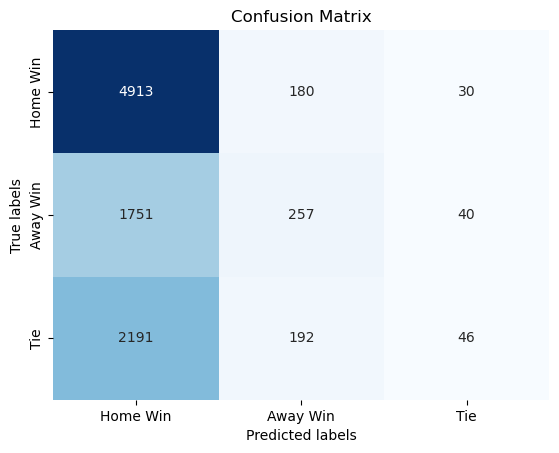

In [90]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy = performance(y_test, gb_pred, gb_model)
models_performance.loc[len(models_performance)] = ['Gradient Boosting', gb_accuracy]

# Logistic Regression

c:\Users\Jordi\anaconda3\envs\MyEnv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.55      0.96      0.70      5123
           2       0.42      0.13      0.20      2048
           X       0.39      0.01      0.01      2429

    accuracy                           0.54      9600
   macro avg       0.45      0.37      0.30      9600
weighted avg       0.48      0.54      0.42      9600



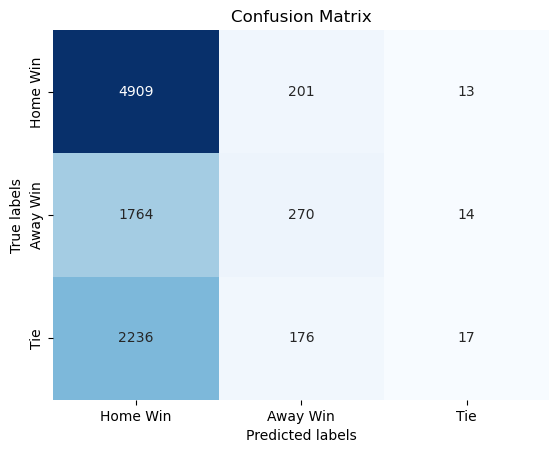

In [91]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)
LR_accuracy = performance(y_test, LR_pred, LR_model)
models_performance.loc[len(models_performance)] = ['Logistic Regression', LR_accuracy]

# Naive Bayes

              precision    recall  f1-score   support

           1       0.67      0.45      0.54      5123
           2       0.29      0.45      0.35      2048
           X       0.29      0.36      0.32      2429

    accuracy                           0.43      9600
   macro avg       0.42      0.42      0.40      9600
weighted avg       0.49      0.43      0.44      9600



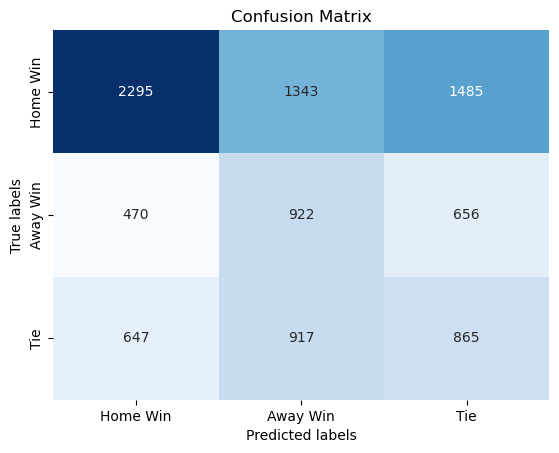

In [92]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)
NB_pred = NB_model.predict(X_test)
NB_accuracy = performance(y_test, NB_pred, NB_model)
models_performance.loc[len(models_performance)] = ['Naive Bayes', NB_accuracy]

# kNN

              precision    recall  f1-score   support

           1       0.56      0.77      0.65      5123
           2       0.29      0.19      0.23      2048
           X       0.27      0.13      0.18      2429

    accuracy                           0.49      9600
   macro avg       0.37      0.36      0.35      9600
weighted avg       0.43      0.49      0.44      9600



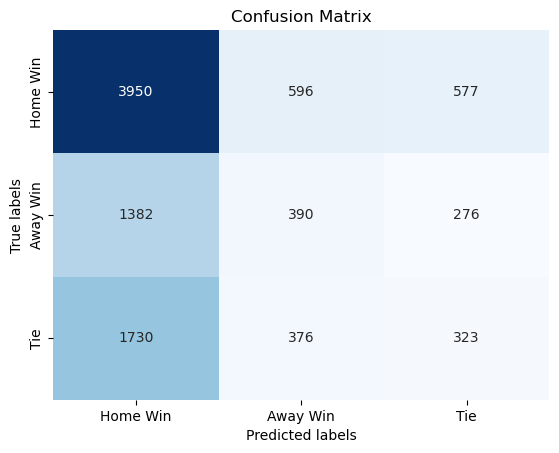

In [93]:
kNN_model = KNeighborsClassifier()
kNN_model.fit(X_train, y_train)
kNN_pred = kNN_model.predict(X_test)
kNN_accuracy = performance(y_test, kNN_pred, kNN_model)
models_performance.loc[len(models_performance)] = ['k Nearest Neighbors', kNN_accuracy]

# Decision Tree

              precision    recall  f1-score   support

           1       0.58      0.57      0.57      5123
           2       0.27      0.27      0.27      2048
           X       0.27      0.27      0.27      2429

    accuracy                           0.43      9600
   macro avg       0.37      0.37      0.37      9600
weighted avg       0.43      0.43      0.43      9600



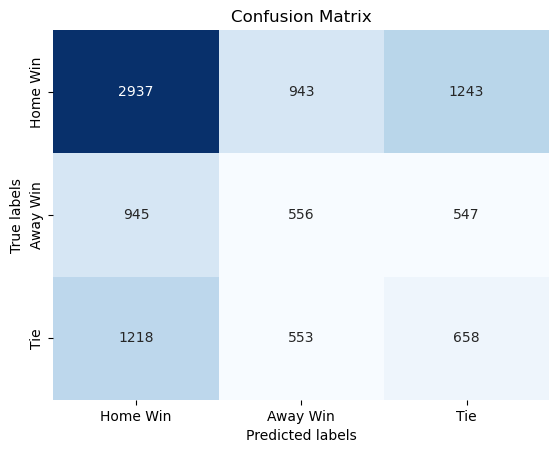

In [94]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_accuracy = performance(y_test, tree_pred, tree_model)
models_performance.loc[len(models_performance)] = ['Decision Trees', tree_accuracy]

# Random Forest

              precision    recall  f1-score   support

           1       0.57      0.75      0.65      5123
           2       0.32      0.20      0.25      2048
           X       0.28      0.18      0.22      2429

    accuracy                           0.49      9600
   macro avg       0.39      0.38      0.37      9600
weighted avg       0.45      0.49      0.46      9600



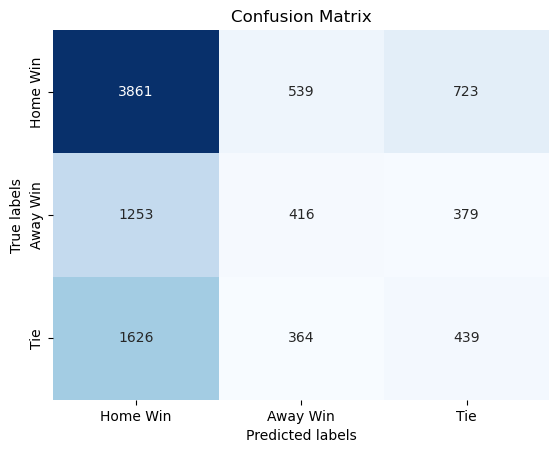

In [95]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_accuracy = performance(y_test, RF_pred, RF_model)
models_performance.loc[len(models_performance)] = ['Random Forest', RF_accuracy]

# Best model?

In [97]:
models_performance = models_performance.sort_values(['accuracy'], ascending=False)
print(models_performance)

                 model  accuracy
0    Gradient Boosting  0.543333
1  Logistic Regression  0.541250
5        Random Forest  0.491250
3  k Nearest Neighbors  0.485729
4       Decision Trees  0.432396
2          Naive Bayes  0.425208


# Feature Importance

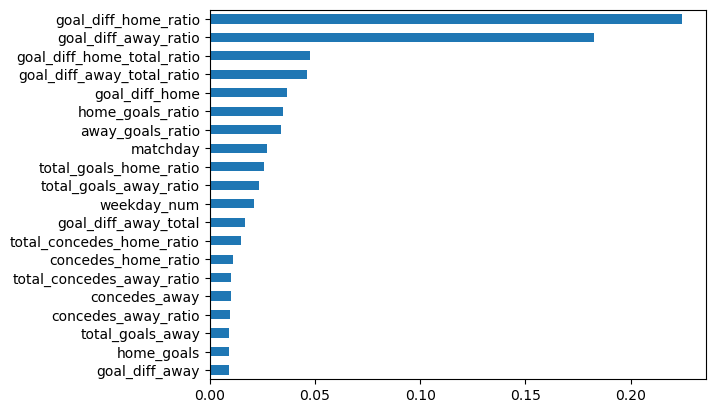

In [108]:
# Get the feature importance of the model
feature_imp = gb_model.feature_importances_

# Get the top 20 features
indices = np.argsort(feature_imp)[-20:][::-1]
feature_names = X.columns
feature_names = feature_names[indices]

# Plot
importances = pd.Series(feature_imp[indices], index=feature_names)
importances.sort_values(ascending=True).plot(kind="barh")
plt.show()